In [ ]:
from urllib2 import urlopen, Request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import os.path 
import datetime 
import sys
import json
import gc


from __future__ import division

import nltk,re, pprint

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

bs = BeautifulSoup(urlopen('http://www.playbill.com/article/broadway-real-estate-com-321997'))
Theatres = DataFrame([{'name': a.getText(), 'url': a['href'], 'address': a.nextSibling[2:]} 
                      for a in bs.find_all("a") if a.has_attr('href') and '/venue/' in a['href']])

Shows = pd.read_csv('Shows.csv')

def getTags(url):
    bs = BeautifulSoup(urlopen('http://www.playbill.com' + url))
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def getTagsFromBs(bs):
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def seasonShows(season):
    seasonJson = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year='+str(season)+'&start=0&limit=1000').readlines()))
    result = []
    for row in seasonJson['rows']:

        bs = BeautifulSoup(row)
        if (bs.find('a').has_attr('href')):
            result.append({'url':bs.find('a')['href'], 'title': bs.find('a').getText()})
    return result

def getProductionHtml(url):
    if (not url.startswith('http://www.playbill.com')):
        url = 'http://www.playbill.com' + url

    filename = 'production/' + url.split('/')[-1] + '.html' 

    if (not os.path.isfile(filename)):
        html = urlopen(url).read()
        f = open(filename, "w")
        f.write(html)
        f.close()
        print 'Wrote ' + filename
    else:
        print filename + ' already exists'

def getHtmlForYear(year):
    print 'Year: ' + str(year)
    [getProductionHtml(x) for x in list(Shows[Shows['year']==year]['url'])]
    

In [ ]:
tagsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == year]['url']):
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            tagsForUrl[url] = '/'.join(getTagsFromBs(bs))
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

In [ ]:
Shows['tags'] = Shows['url'].apply(lambda url: tagsForUrl[url])

In [134]:
Shows['decade'] = 10 * (Shows['year'] // 10)
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))
Shows['isMusical'] = Shows.tags.str.contains('Musical')
Shows['isComedy'] = Shows.tags.str.contains('Comedy')
Shows['isDrama'] = Shows.tags.str.contains('Drama')
Shows['isPlay'] = Shows.tags.str.contains('Play')

In [ ]:
Shows.to_csv('Shows.csv',index=False,encoding='utf-8')

In [15]:
print len(Shows[Shows.tags.str.contains('Original')])
print len(Shows)

10321
12886


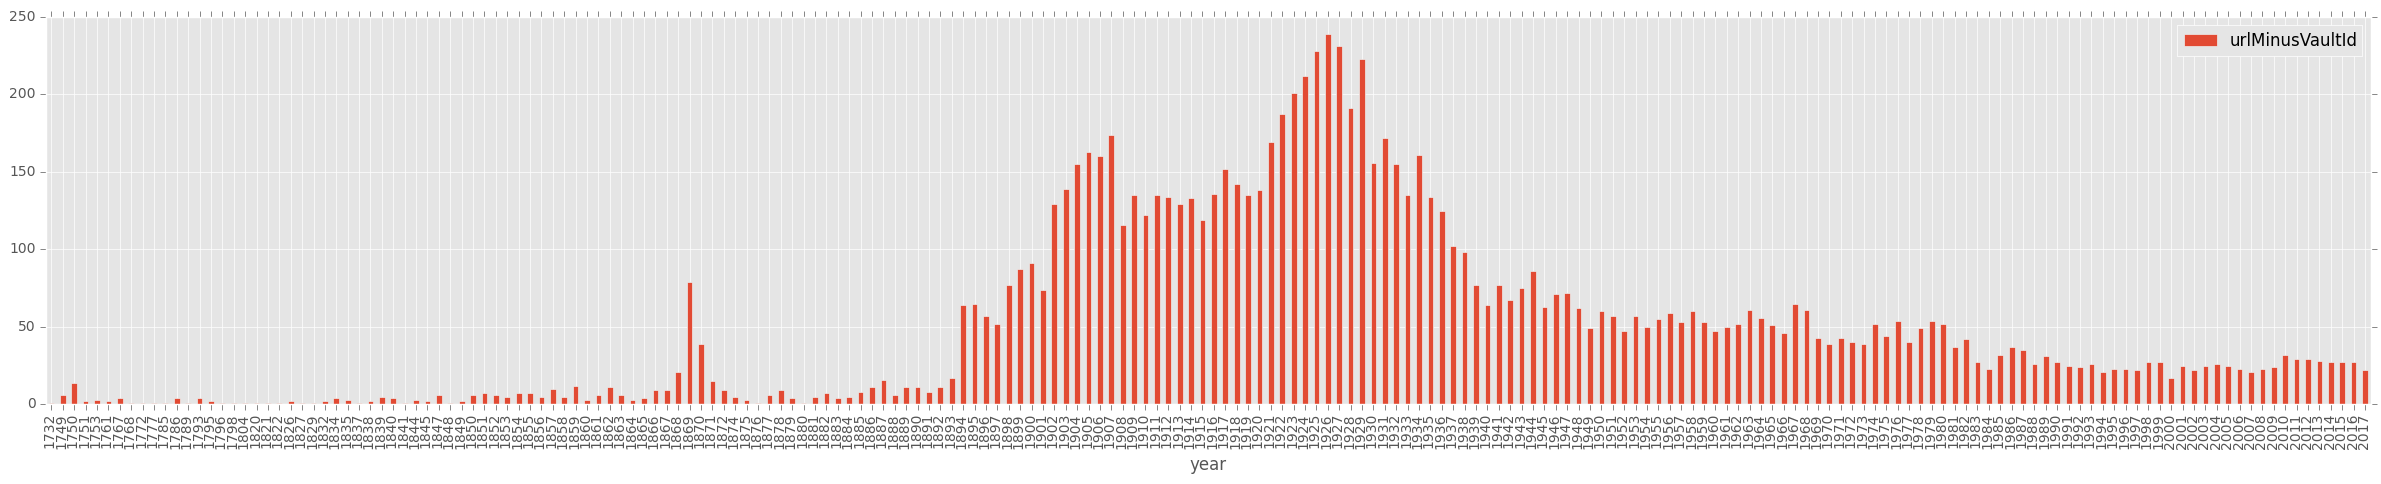

In [34]:
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))

Originals = Shows[Shows.tags.str.contains('Original')]
Originals.groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [112]:
Shows['decade'] = 10 * (Shows['year'] // 10)

In [59]:
nltk.FreqDist(list([y for x in list(Shows.tags.str.split('/')) for y in x])).most_common()

[('Broadway', 12764),
 ('Original', 10321),
 ('Play', 4775),
 ('Musical', 2782),
 ('Comedy', 2779),
 ('Drama', 1924),
 ('Revue', 505),
 ('Opera', 295),
 ('Special', 269),
 ('Farce', 247),
 ('Operetta', 235),
 ('One Act', 201),
 ('Tragedy', 159),
 ('Solo', 122),
 ('Off-Broadway', 122),
 ('Concert', 110),
 ('Play with Music', 102),
 ('Dance', 97),
 ('Vaudeville', 44),
 ('Benefit', 38),
 ('Burlesque', 37),
 ('Thriller', 21),
 ('Magic', 6),
 ('Holiday', 4),
 ('Story', 1),
 ('Theatrical Experience', 1)]

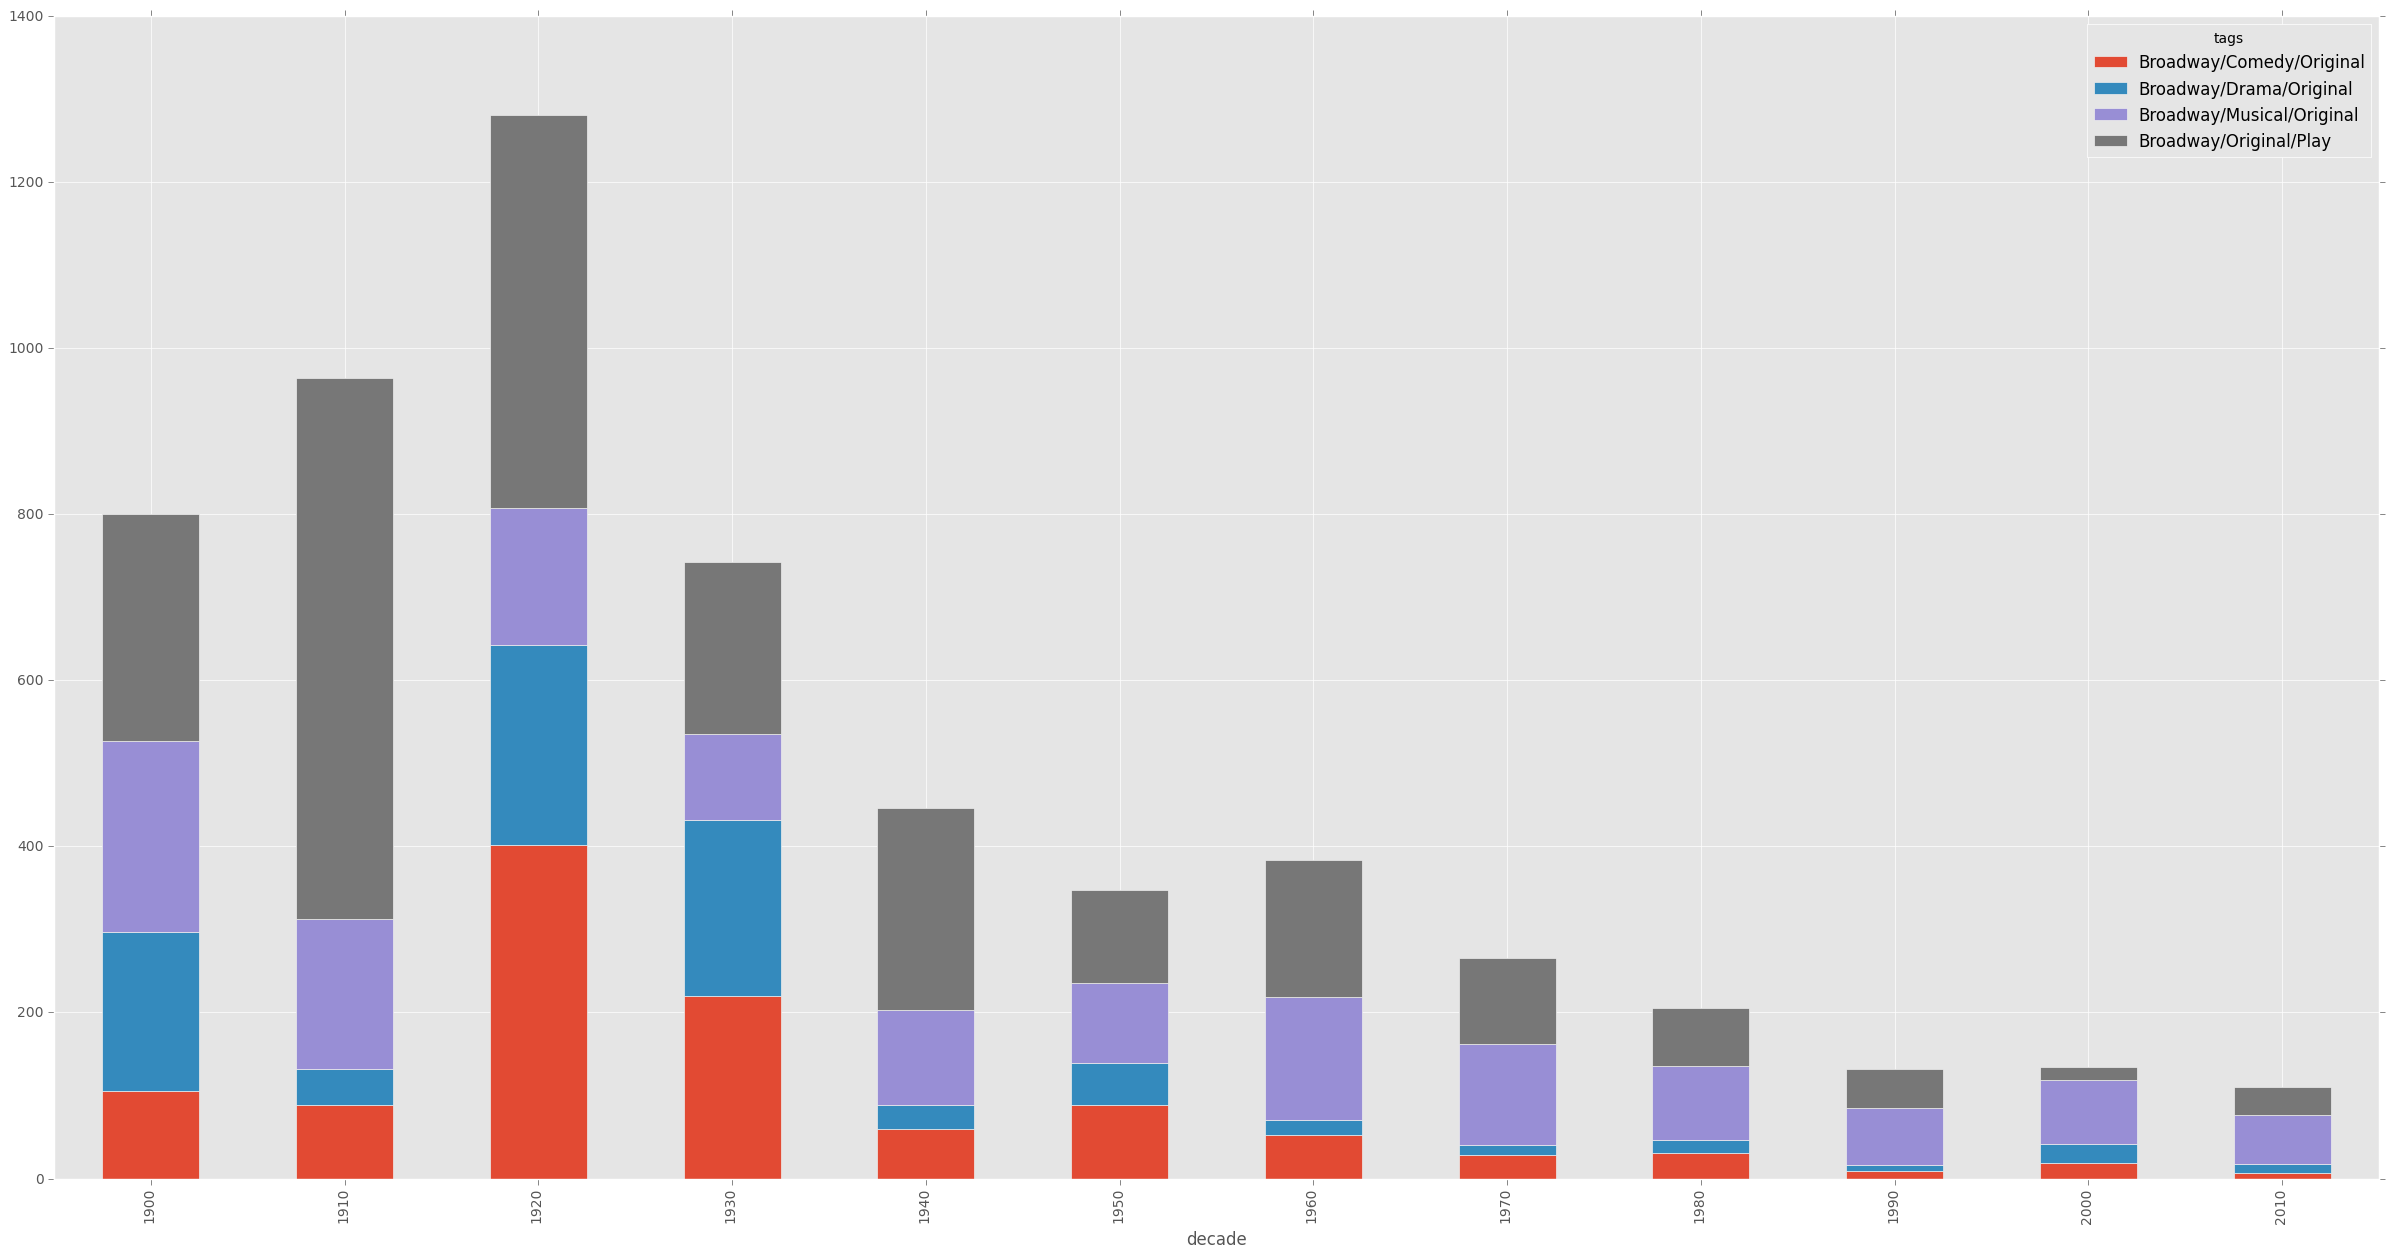

In [147]:
Shows[(Shows.year>1900) & (Shows.tags.isin(['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']))] \
    .groupby(['decade','tags']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))


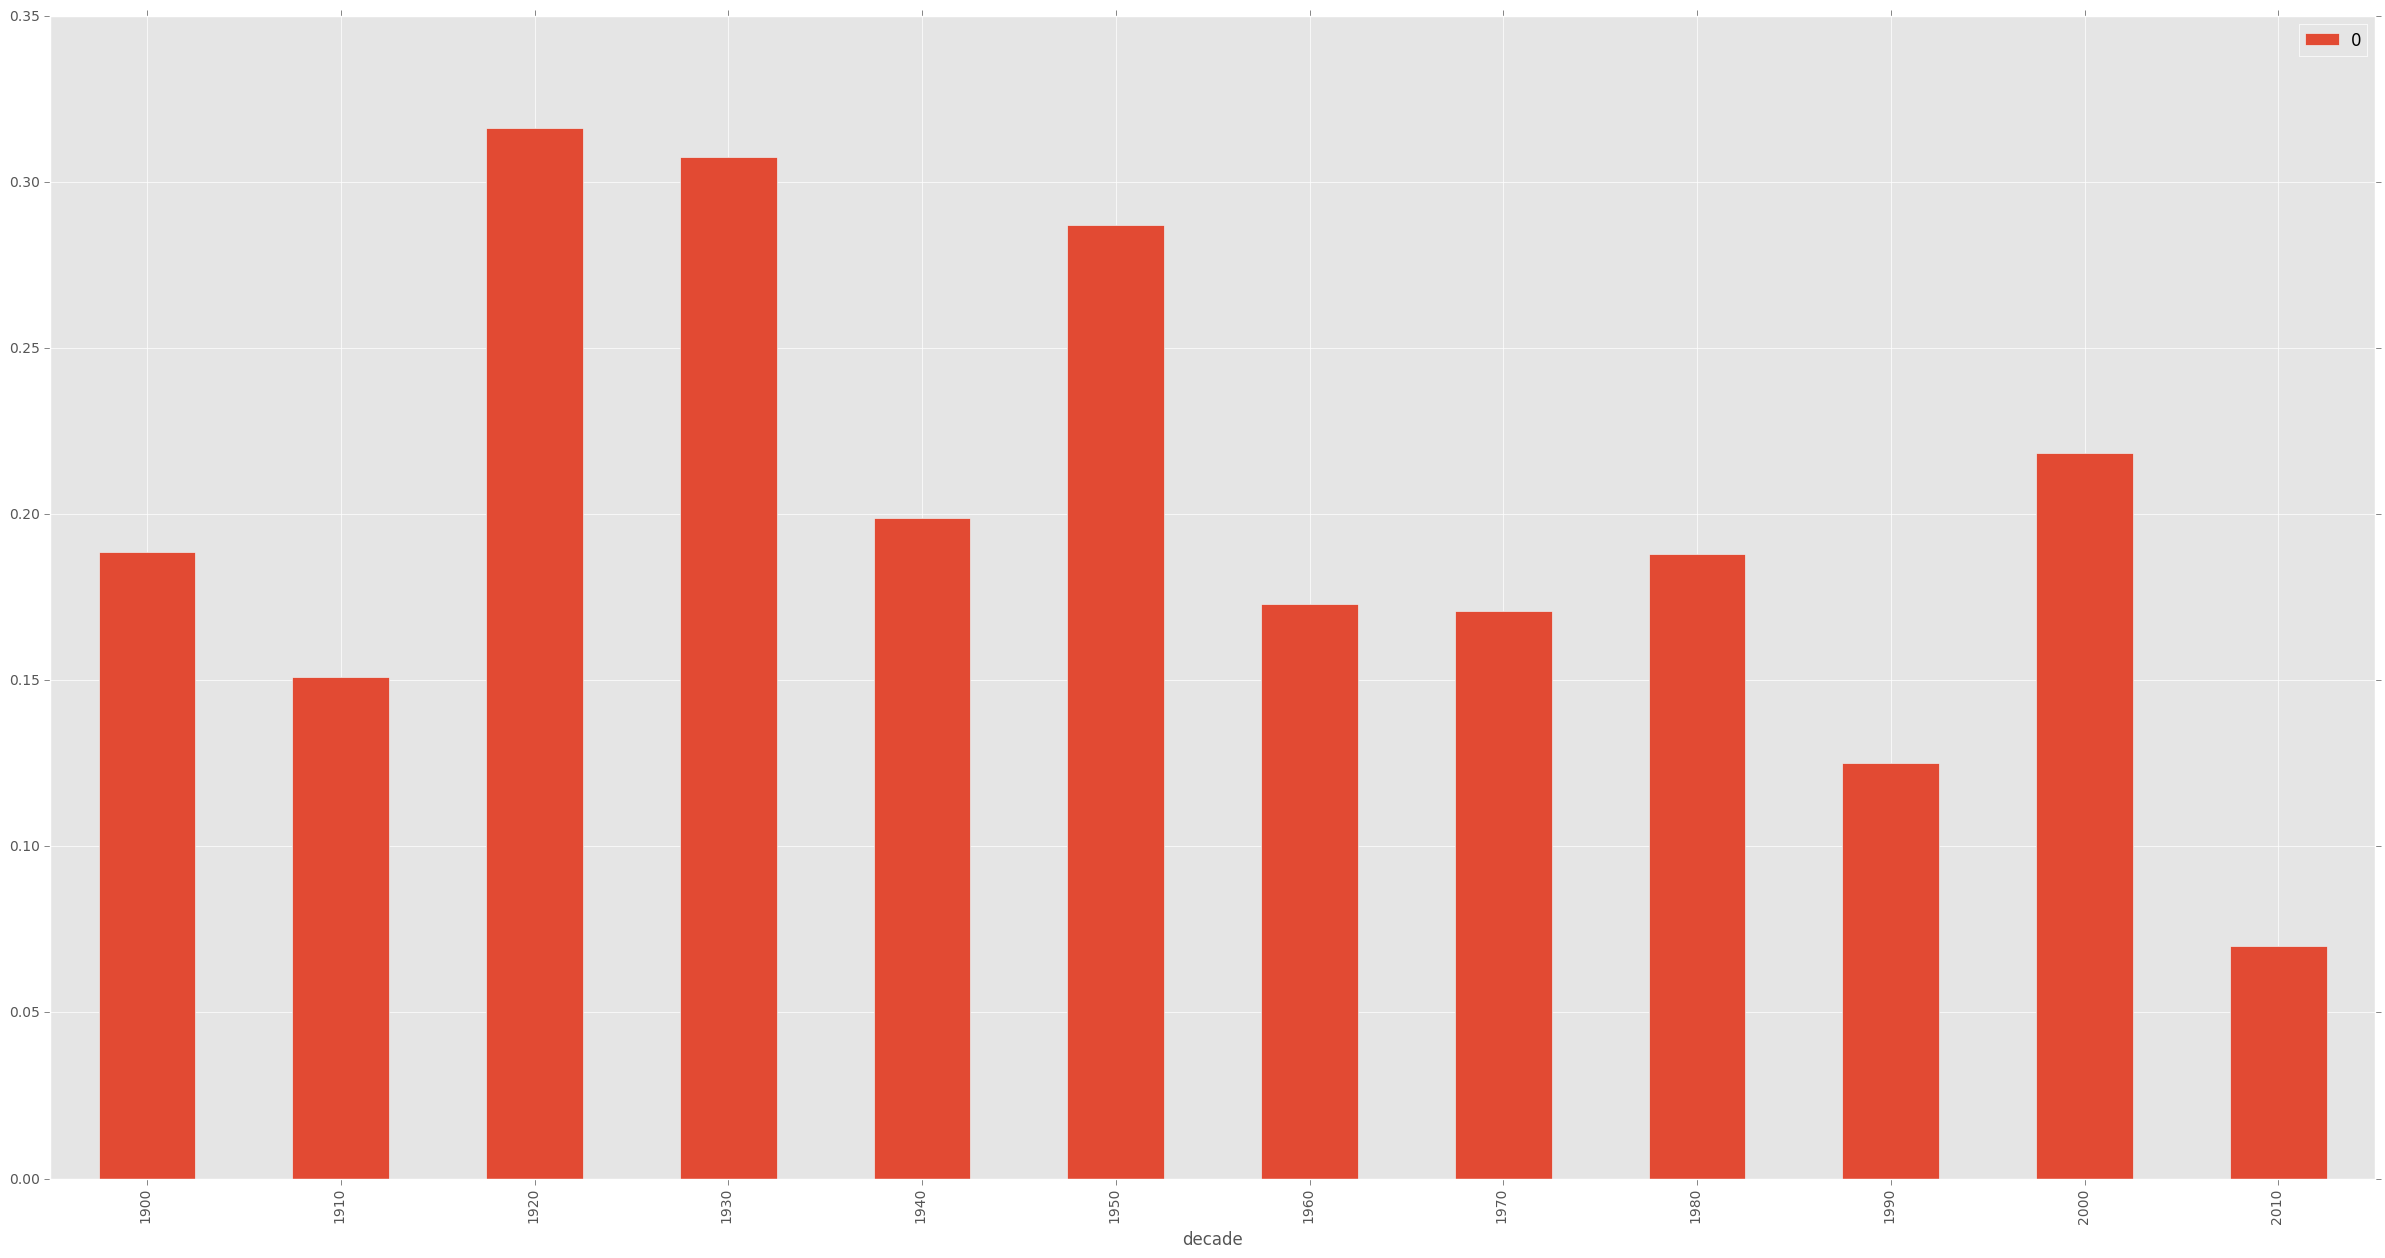

In [156]:
t = Shows[(Shows.year>1900)] \
    .groupby(['decade','isComedy']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
t['Total'] = t.sum(axis=1)

DataFrame(t[True] / t['Total']).plot.bar(figsize=(30,15))

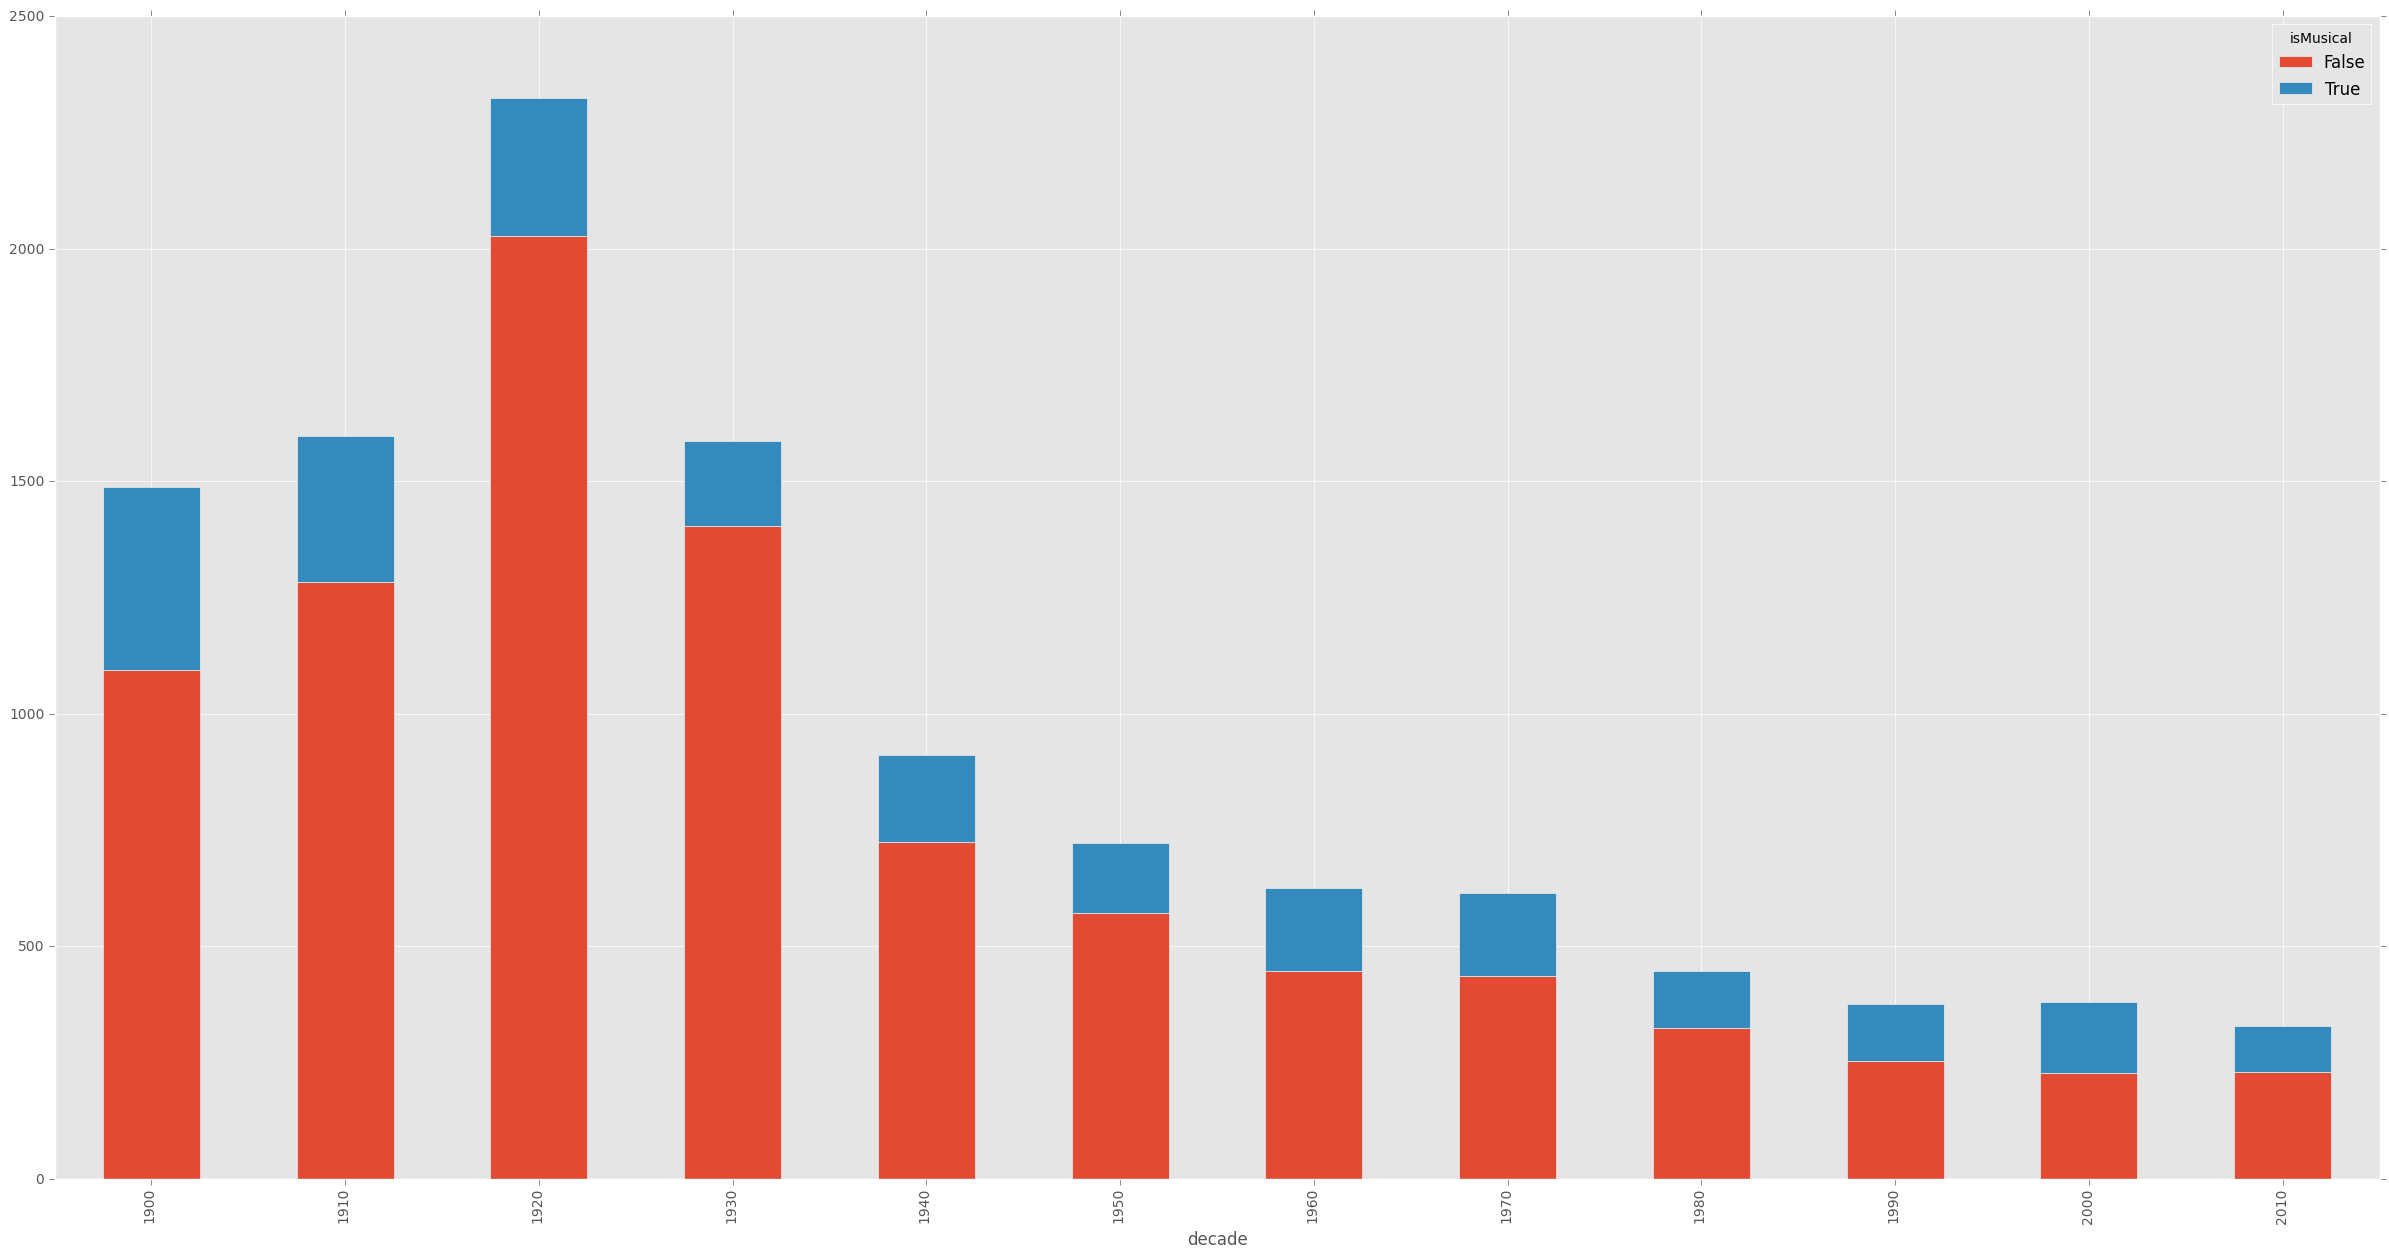

In [149]:
Shows[(Shows.year>1900)].groupby(['decade','isMusical']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))

In [151]:
Shows[~Shows.isMusical]

,title,url,year,tags,urlMinusVaultId,decade,isMusical,isComedy,isDrama,isPlay
0,The Recruiting Officer,/production/the-recruiting-officer-new-theatre...,1732,Broadway/Original/Play,/production/the-recruiting-officer-new-theatre,1730,False,False,False,True
1,The Mock Doctor,/production/the-mock-doctor-nassau-street-thea...,1749,Broadway/Original/Play,/production/the-mock-doctor-nassau-street-theatre,1740,False,False,False,True
2,The Devil to Pay,/production/the-devil-to-pay-nassau-street-the...,1749,Broadway/Drama/Original,/production/the-devil-to-pay-nassau-street-the...,1740,False,False,True,False
4,Richard III,/production/king-richard-iii-nassau-street-the...,1749,Broadway/Original/Play,/production/king-richard-iii-nassau-street-the...,1740,False,False,False,True
5,Spanish Friar,/production/spanish-friar-nassau-street-theatr...,1749,Broadway/Original/Play,/production/spanish-friar-nassau-street-theatre,1740,False,False,False,True
6,The Orphan,/production/the-orphan-nassau-street-theatre-v...,1749,Broadway/Original/Play,/production/the-orphan-nassau-street-theatre,1740,False,False,False,True
7,The Stage Coach,/production/the-stage-coach-nassau-street-thea...,1750,Broadway/Original/Play,/production/the-stage-coach-nassau-street-theatre,1750,False,False,False,True
8,Love for Love,/production/love-for-love-nassau-street-theatr...,1750,Broadway/Comedy/Original/Play,/production/love-for-love-nassau-street-theatre,1750,False,True,False,True
9,The Recruiting Officer,/production/the-recruiting-officer-nassau-stre...,1750,Broadway/Play,/production/the-recruiting-officer-nassau-stre...,1750,False,False,False,True
10,Cato,/production/cato-nassau-street-theatre-vault-0...,1750,Broadway/Original/Play,/production/cato-nassau-street-theatre,1750,False,False,False,True


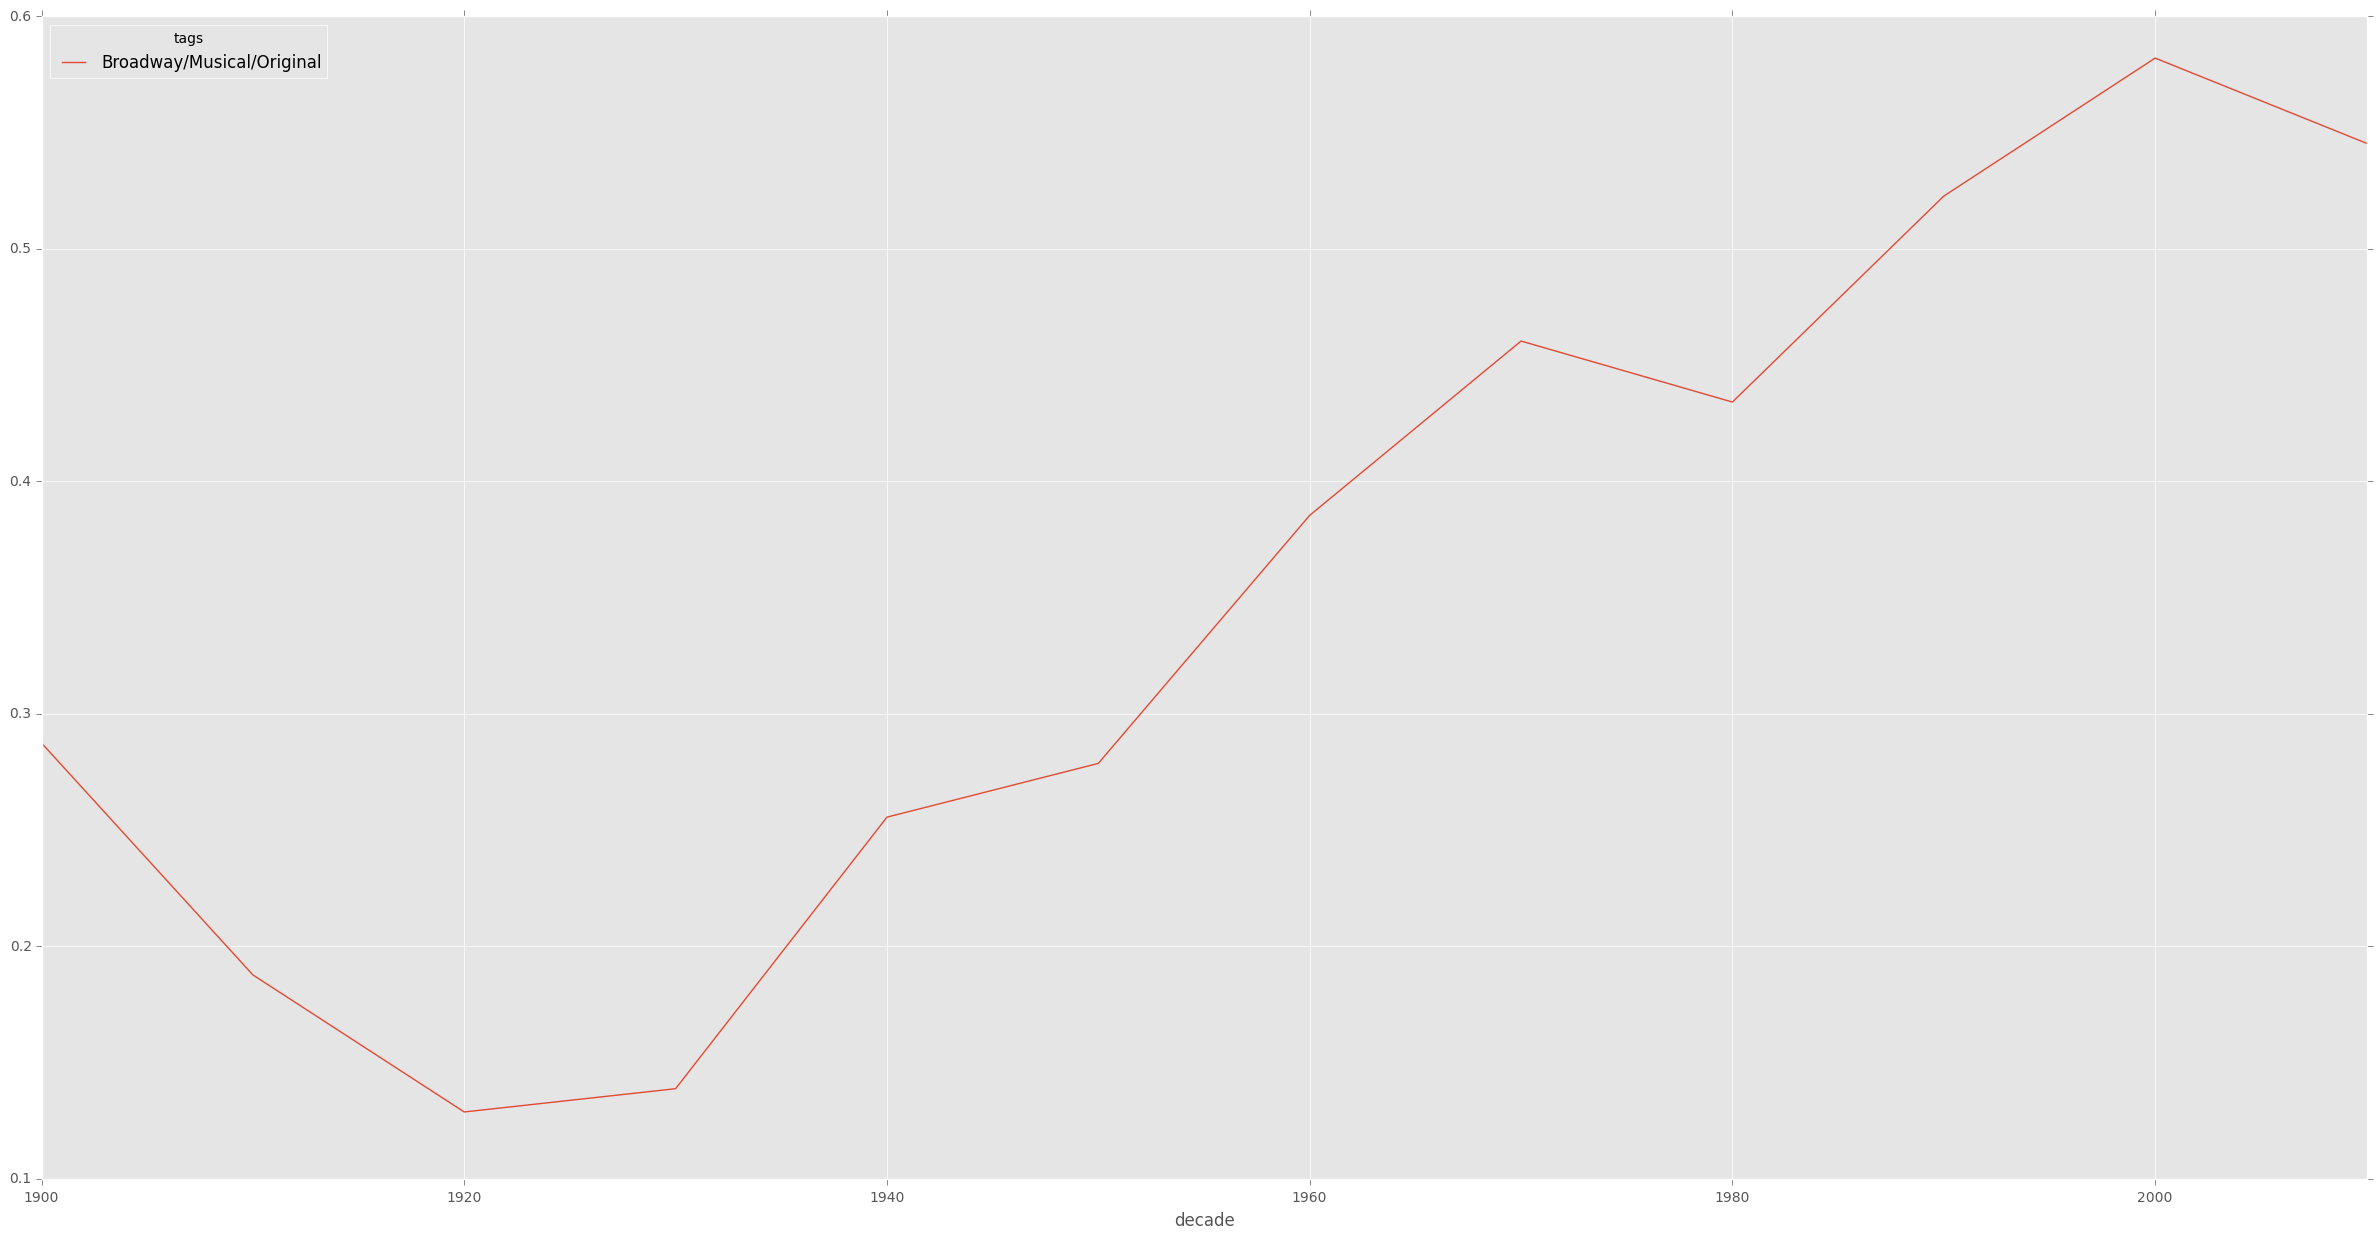

In [113]:
t = Shows[(Shows.year>1900) & (Shows.tags.isin(['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']))] \
    .groupby(['decade','tags']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
    
t['Total'] = t.sum(axis=1)

for tag in ['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']:
    t[tag] = t[tag] / t['Total']
    
t[['Broadway/Musical/Original']].plot(figsize=(30,15))

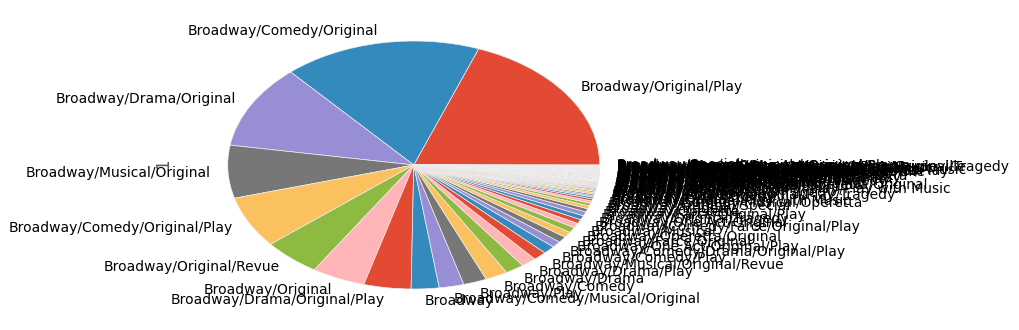

In [128]:
DataFrame(nltk.FreqDist(list(Shows[Shows.year.between(1920,1930)].tags)).most_common()).set_index(0)[1].plot.pie()

In [63]:
Shows[Shows.tags.str.contains('Theatrical Experience')]['url'][12824]

'/production/the-illusionists-turn-of-the-century-lunt-fontanne-theatre-2016-2017'

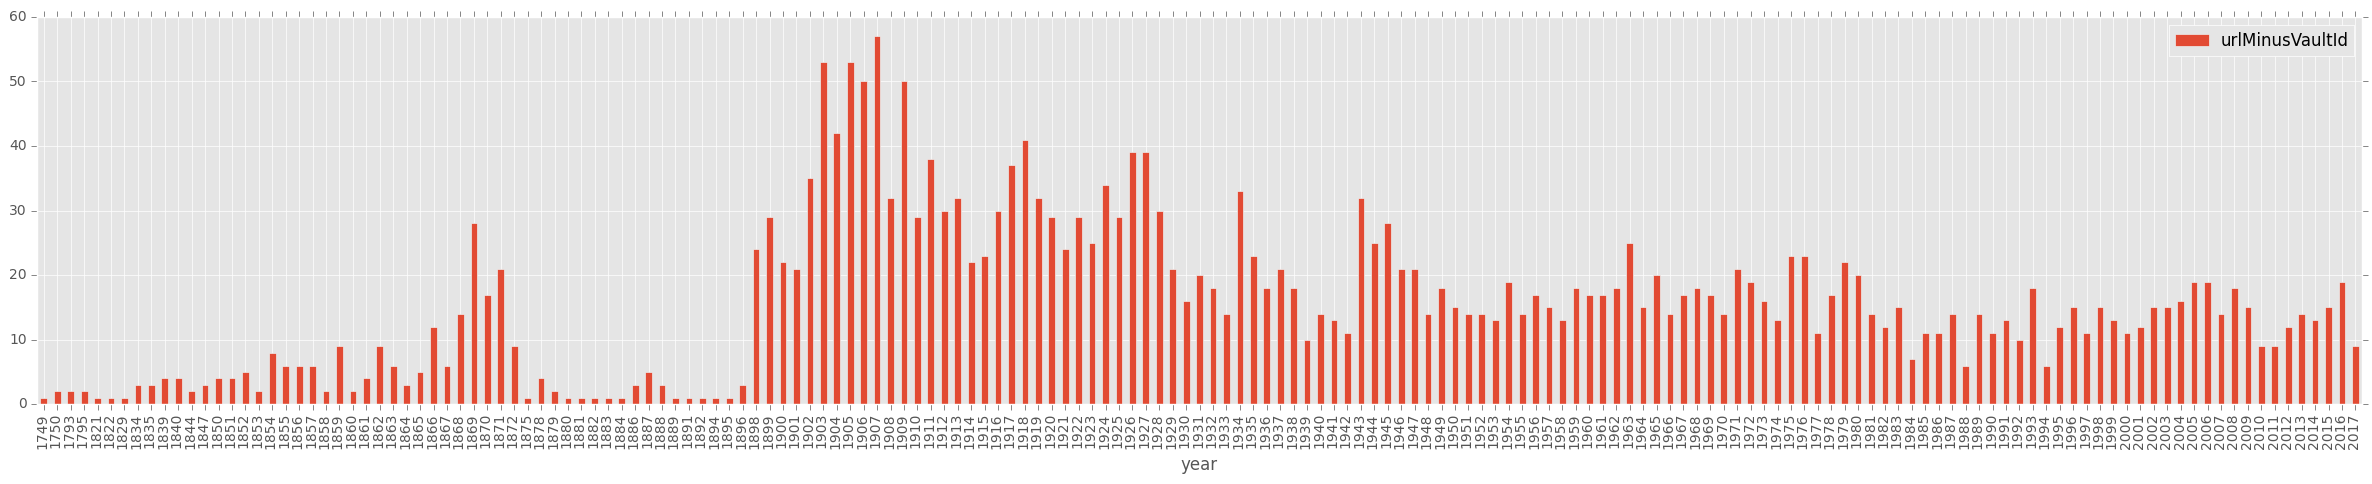

In [69]:
Shows[Shows.tags.str.contains('Musical')].groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [54]:
Shows[Shows.tags.str.contains('Thriller')]

,title,url,year,tags,urlMinusVaultId
2275,A Race Across the Continent,/production/a-race-across-the-continent-thalia...,1907,Broadway/Original/Play/Thriller,/production/a-race-across-the-continent-thalia...
2278,Convict 999,/production/convict-999-thalia-theatre-vault-0...,1907,Broadway/Original/Play/Thriller,/production/convict-999-thalia-theatre
2330,Bunco in Arizona,/production/bunco-in-arizona-american-theatre-...,1907,Broadway/Original/Play/Thriller,/production/bunco-in-arizona-american-theatre
2627,Billy,/production/billy-dalys-theatre-vault-0000012730,1909,Broadway/Original/Thriller,/production/billy-dalys-theatre
3165,The Whip,/production/the-whip-manhattan-opera-house-vau...,1912,Broadway/Original/Play/Thriller,/production/the-whip-manhattan-opera-house
7414,Murder at the Vanities,/production/murder-at-the-vanities-new-amsterd...,1933,Broadway/Comedy/Drama/Musical/Original/Thriller,/production/murder-at-the-vanities-new-amsterd...
8533,Angel Street,/production/angel-street-john-golden-theatre-v...,1941,Broadway/Original/Play/Thriller,/production/angel-street-john-golden-theatre
8839,Hand in Glove,/production/hand-in-glove-playhouse-theatre-va...,1944,Broadway/Original/Thriller,/production/hand-in-glove-playhouse-theatre
8922,The Secret Room,/production/the-secret-room-royale-theatre-vau...,1945,Broadway/Original/Thriller,/production/the-secret-room-royale-theatre
9172,Angel Street,/production/angel-street-city-center-vault-000...,1947,Broadway/Play/Thriller,/production/angel-street-city-center


/Users/sunkevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
print len(set(Originals[Originals.year > 1970]['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))))
print len(Originals[Originals.year > 1970]['url'])

1452
1456


In [ ]:
[getHtmlForYear(y) for y in range(1700,2018)]

In [ ]:
bss = [BeautifulSoup(urlopen(url)) for url in list(Theatres['url'])]

In [ ]:
nltk.Text(nltk.word_tokenize(''.join(theaterDescriptions))).collocations()

In [ ]:
theaterDescriptions = []

for i in range(39):    
    print i
    
    try:
        bs = bss[i]

        bspBio = bs.find('div', class_='bsp-bio')

        bspBioTitle = bspBio.find('h2', class_='bsp-bio-title').getText()

        print bspBioTitle

        bspBioText = ''
        bspBioFullTextUrl = ''
        if (bspBio.find('div', class_='bsp-bio-text')):
            bspBioText =  bspBio.find('div', class_='bsp-bio-text').getText('\n')
            if (bspBio.find('div', class_='bsp-bio-text').find('a')):
                if (bspBio.find('div', class_='bsp-bio-text').find('a').has_attr('href')):
                    bspBioFullTextUrl = bspBio.find('div', class_='bsp-bio-text').find('a')['href']

        bspBioLists =bspBio.find('div', class_='bsp-bio-lists')
        bspBioListPairs = [(re.sub(':$', '', li.find('span').getText()), li.find('span').nextSibling) for li in bspBioLists.find_all('li')]


        print bspBioText
        theaterDescriptions.append(bspBioText)
        
        print bspBioFullTextUrl
        print bspBioListPairs
    except:
        print("Unexpected error:", sys.exc_info()[0])

In [ ]:
t = DataFrame(theaterDescriptions)
t[0]=t[0].str.strip()
t.to_csv('theaterDescriptions.csv',index=False,encoding='utf-8')


In [ ]:
text = nltk.word_tokenize(theaterDescriptions[10])
nltk.pos_tag(text)

In [ ]:
season2017 = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year=2017&start=0&limit=1000').readlines()))


In [ ]:


Shows = DataFrame([{'year': year, 'url': x['url'], 'title': x['title']}  for year in range(1701,2018) for x in seasonShows(year)])

Shows['title'] = Shows['title'].str.strip()



In [ ]:
print len(Shows.groupby('url').count())
print len(Shows)

In [ ]:
list(Shows[Shows['url'].str.contains('carousel')]['url'])

In [ ]:
carousels

In [ ]:
url =  '/production/carousel-2017-2018'

url = 'http://www.playbill.com' + url

bs = BeautifulSoup(urlopen(url))

In [ ]:
tags = [getTags(url) for url in list(Shows['url'])]

In [ ]:
getTags('/production/carousel-2017-2018')

In [ ]:
carousels= list(Shows[Shows['url'].str.contains('carousel')]['url'])

In [ ]:
previousShows = 'http://www.playbill.com/ajax/loadVenueShow.jsp?id=00000150-aa9f-d8be-af71-ffbf689b0003&start=0&limit=1000&venue=00000150-aacd-d8be-af71-ffef18860005'

In [ ]:
url='http://www.playbill.com/production/carousel-2017-2018'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
url='http://www.playbill.com/venue/imperial-theatre-vault-0000000201'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
url='http://www.playbill.com/production/carousel-2017-2018'
bs = BeautifulSoup(urlopen(url))

In [ ]:
getProductionHtml('http://www.playbill.com/production/carousel-2017-2018')


In [ ]:
str(urlopen(url))

In [ ]:
url.startswith('http://www.playbill.com/')

In [ ]:
f = open('production/my-fair-lady-uris-theatre-vault-0000011053.html', "r")
bs = BeautifulSoup(f.read())
f.close()

bs

In [ ]:
[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
getTagsFromBs(bs)